<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Init-data" data-toc-modified-id="Init-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Init data</a></span><ul class="toc-item"><li><span><a href="#Estaciones" data-toc-modified-id="Estaciones-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Estaciones</a></span></li><li><span><a href="#Data-Mediciones" data-toc-modified-id="Data-Mediciones-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Data Mediciones</a></span></li><li><span><a href="#Ozono" data-toc-modified-id="Ozono-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Ozono</a></span></li></ul></li><li><span><a href="#Ver-mediciones-contra-latitud-(eje-Y)" data-toc-modified-id="Ver-mediciones-contra-latitud-(eje-Y)-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Ver mediciones contra latitud (eje Y)</a></span></li></ul></div>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd

from tqdm import tqdm_notebook
import requests
import json

pd.options.mode.chained_assignment = None

from axo_src.utils import calcular_areas_influencia, agg_info_por_area, wgs84_to_web_mercator, get_local_from_s3

%matplotlib inline

# Init data

## Estaciones

In [2]:
estaciones = pd.read_csv('/data/calidad_aire_presidencia/data_estaciones_sinaica_cvegeo.csv')
mask = (estaciones.lat.between(14, 34.5)) & (estaciones.long.between(-120, -70))
estaciones = estaciones[mask].rename(columns={'id':'estacionesid'})

print(estaciones.shape)
estaciones.head()

(180, 10)


,estacionesid,cvegeo,radius,_id,lat,long,nombre,codigo,redesid,date-insert
0,58,1000500013698027,0.001,5b8850e3e2705c1932e8300b,24.034472,-104.645028,ITD,ITD,42,2018-08-30 20:17:39.219
1,59,1000500014573001,0.001,5b8850e3e2705c1932e8300c,24.051556,-104.611361,IPN,IPN,42,2018-08-30 20:17:39.219
2,60,1000500015266011,0.001,5b8850e3e2705c1932e8300d,24.026778,-104.692975,SRNyMA,SRN,42,2018-08-30 20:17:39.219
3,65,1000700010166050,0.001,5b8850e3e2705c1932e8300e,25.551222,-103.502528,Campestre,CAM,43,2018-08-30 20:17:39.219
4,68,1100700010226014,0.001,5b8850e3e2705c1932e83011,20.517500,-100.815556,Policía,POL,45,2018-08-30 20:17:39.219


## Data Mediciones

In [3]:
mediciones = pd.read_csv('/data/calidad_aire_presidencia/data_mediciones_todas_estaciones_2.csv')
print(mediciones.shape)
mediciones.head()

(3240000, 8)


,city,estacionesid,fecha,hora,parametro,state,validoorig,valororig
0,Durango,58,2018-08-01,13,PM10,Durango,1,988.61
1,Durango,58,2018-08-01,14,PM10,Durango,1,988.61
2,Durango,58,2018-08-01,15,PM10,Durango,1,988.60
3,Durango,58,2018-08-01,16,PM10,Durango,1,988.63
4,Durango,58,2018-08-01,17,PM10,Durango,1,988.63


In [4]:
estaciones_ciudad = mediciones[['city', 'state', 'estacionesid']].drop_duplicates()
estaciones_ciudad = estaciones_ciudad.merge(estaciones[['estacionesid', 'lat', 'long', 'nombre']],
                                            on='estacionesid')
print(estaciones_ciudad.shape)
estaciones_ciudad.head()

(121, 6)


,city,state,estacionesid,lat,long,nombre
0,Durango,Durango,58,24.034472,-104.645028,ITD
1,Durango,Durango,59,24.051556,-104.611361,IPN
2,Durango,Durango,60,24.026778,-104.692975,SRNyMA
3,Gómez Palacio,Durango,65,25.551222,-103.502528,Campestre
4,Celaya,Guanajuato,68,20.517500,-100.815556,Policía


In [5]:
estaciones_ciudad.groupby('city').estacionesid.nunique().sort_values(ascending=False).head()

city
Valle de México    32
Monterrey          11
Guadalajara        10
Toluca              6
León                3
Name: estacionesid, dtype: int64

## Ozono

In [6]:
medicion_contaminante = mediciones[mediciones.parametro=='O3']

# De acuerdo al análisis anterior, es buena idea filtrar valores demasiado grandes. Vamos a usar
# como filtro el mínimo valor de ozono para establecer calidad del aire muy mala según SEMARNAT que es 0.6 ppm
medicion_contaminante = medicion_contaminante[medicion_contaminante.valororig.between(0, 0.7)]

medicion_contaminante = medicion_contaminante.groupby('estacionesid').agg({'valororig':['mean', 'count'],
                                                                           'validoorig':'mean'}).reset_index()
medicion_contaminante.columns = ['estacionesid', 'valororig', 'num_registros', 'validoorig']

medicion_contaminante = medicion_contaminante.merge(estaciones[['estacionesid', 'lat', 'long', 'nombre']],
                                                    on='estacionesid')
medicion_contaminante = medicion_contaminante.merge(mediciones[['estacionesid', 'city']].drop_duplicates(),
                                                    on='estacionesid')

print(medicion_contaminante.shape)
medicion_contaminante.head()

(107, 8)


,estacionesid,valororig,num_registros,validoorig,lat,long,nombre,city
0,33,0.290461,143,1,21.883781,-102.295825,Centro,Aguascalientes
1,38,0.039118,2,1,32.631317,-115.444631,UABC,Mexicali
2,39,0.017146,5858,1,32.639722,-115.506389,COBACH,Mexicali
3,41,0.010098,365,1,32.603639,-115.485944,CESPM,Mexicali
4,46,0.021328,9040,1,32.529461,-116.921281,Laboratorio,Tijuana


In [7]:
mask = (medicion_contaminante.num_registros>2400)
filtered_medicion = medicion_contaminante[mask]

print(filtered_medicion.shape)
filtered_medicion.head()

(96, 8)


,estacionesid,valororig,num_registros,validoorig,lat,long,nombre,city
2,39,0.017146,5858,1,32.639722,-115.506389,COBACH,Mexicali
4,46,0.021328,9040,1,32.529461,-116.921281,Laboratorio,Tijuana
5,53,0.031892,8795,1,28.632775,-106.038867,SUR,Chihuahua
6,54,0.038020,4970,1,28.652228,-106.085358,Centro,Chihuahua
7,56,0.011542,5583,1,25.522694,-103.395806,CONALEP,Torreón


# Ver mediciones contra latitud (eje Y)

- Puede que exista evidencia de la relación entre cantidad de ozono y latitud, ver http://www.aire.cdmx.gob.mx/descargas/publicaciones/simat-cartel-comportamiento-o3.pdf

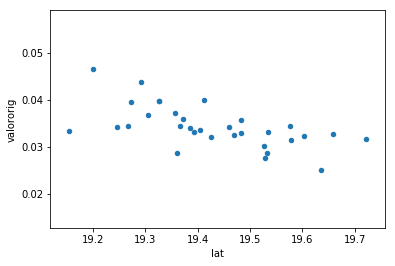

In [11]:
filtered_medicion[filtered_medicion.city=='Valle de México'].plot.scatter('lat', 'valororig')

In [15]:
mask = (mediciones.parametro=='O3') & (mediciones.estacionesid.isin(filtered_medicion.estacionesid))

ozono_hora = mediciones[mask]

# De acuerdo al análisis anterior, es buena idea filtrar valores demasiado grandes. Vamos a usar
# como filtro el mínimo valor de ozono para establecer calidad del aire muy mala según SEMARNAT que es 0.6 ppm
ozono_hora = ozono_hora[ozono_hora.valororig.between(0, 0.7)]

ozono_hora = ozono_hora.groupby(['estacionesid', 'hora']).valororig.mean().reset_index()
# ozono_hora.columns = ['estacionesid', 'valororig', 'num_registros', 'validoorig']

# ozono_hora = ozono_hora.merge(estaciones[['estacionesid', 'lat', 'long', 'nombre']],
#                                                     on='estacionesid')
# ozono_hora = ozono_hora.merge(mediciones[['estacionesid', 'city']].drop_duplicates(),
#                                                     on='estacionesid')

print(ozono_hora.shape)
ozono_hora.head()

(2298, 3)


,estacionesid,hora,valororig
0,39,0,0.011278
1,39,1,0.010650
2,39,2,0.009846
3,39,3,0.009651
4,39,4,0.009371
